In [58]:
import torch
from tqdm import tqdm
from transformers import MaskFormerForInstanceSegmentation, MaskFormerImageProcessor
import cv2
import numpy as np
import torch.nn.functional as NNF
from fiftyone import ViewField as F
import fiftyone as fo
from cleanlab.segmentation.rank import get_label_quality_scores, issues_from_scores 
from cleanlab.segmentation.summary import display_issues
from cleanlab.segmentation.filter import find_label_issues 
import time
from transformers import MaskFormerForInstanceSegmentation
from PIL import Image
import albumentations as A


In [59]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET_NAME = "TRAIN_PANOPTIC_DATASET"
MODEL_PATH =  "/mnt/hdd/maryam/models/model_panoptik_27k_saved_100epochs/last_model"
MODEL_NAME = "maskformer-27k-100epochs"
# CATEGORIES_JSON_PATH =os.path.join(TEST_DATASET_PATH, "panoptic_seaai_categories.json")
CLASS_NAMES = ['AERIAL_ANIMAL', 'CONSTRUCTION', 'CONTAINER', 'FAR_AWAY_OBJECT', 'FLOTSAM', 'HUMAN_IN_WATER', 'LAND', 'MARITIME_ANIMAL', 'MOTORBOAT', 'OWN_BOAT', 'PILLAR_BUOY', 'SAILING_BOAT_WITH_CLOSED_SAILS', 'SAILING_BOAT_WITH_OPEN_SAILS', 'SHIP', 'SKY', 'SPHERICAL_BUOY', 'WATER', 'WATERCRAFT']
TARGET_SIZE = (640, 512)

In [60]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

image_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

In [61]:
dataset = fo.load_dataset(DATASET_NAME) 

In [83]:
# dataset_view = dataset.match(F("filepath").ends_with(["17995902_r.jpg", "15616105_r.jpg", "23562072_r.jpg"])) #change this to be smaller than the entire dataset if you want to do a quick test
dataset_view = dataset.match(F("metadata.height")==640) 

In [84]:
len(dataset), len(dataset_view)

(274555, 250206)

In [85]:
model = MaskFormerForInstanceSegmentation.from_pretrained(MODEL_PATH).to(DEVICE)
processor = MaskFormerImageProcessor.from_pretrained(MODEL_PATH, use_tensors=True)

In [86]:
model_labels =  model.config.id2label
[v for k,v in model_labels.items()]

['AERIAL_ANIMAL',
 'CONSTRUCTION',
 'CONTAINER',
 'FAR_AWAY_OBJECT',
 'FLOTSAM',
 'HUMAN_IN_WATER',
 'LAND',
 'MARITIME_ANIMAL',
 'MOTORBOAT',
 'OWN_BOAT',
 'PILLAR_BUOY',
 'SAILING_BOAT_WITH_CLOSED_SAILS',
 'SAILING_BOAT_WITH_OPEN_SAILS',
 'SHIP',
 'SKY',
 'SPHERICAL_BUOY',
 'WATER',
 'WATERCRAFT']

In [87]:
label_to_id = model.config.label2id

In [88]:
def transform_mask_to_image_size(image_size, bbox, mask, index):
    height, width = image_size
    image_size_mask = np.zeros(image_size, dtype=np.uint8)
    
    # Unpack bounding box coordinates
    left, top, bbox_width, bbox_height = bbox
    # Calculate absolute coordinates
    abs_top = int(top * height)
    abs_left = int(left * width)
    abs_bottom = min(abs_top + int(bbox_height * height), height)
    abs_right = min(abs_left + int(bbox_width * width), width)
    
    # Place mask in image mask
    image_size_mask[abs_top:abs_bottom, abs_left:abs_right] = mask * index

    return image_size_mask

def create_image_mask(annotations, image_size):
    """
    Create an image mask from a list of mask annotations.
    
    Args:
    - annotations: List of annotations, where each annotation is a dictionary with keys 'bounding_box', 'mask', and 'index'.
    - image_size: Tuple (height, width) representing the size of the image mask to be created.
    
    Returns:
    - image_mask: NumPy array representing the image mask with object indexes.
    """
    height, width = image_size
    image_mask = np.zeros((height, width), dtype=np.uint8)
    
    for annotation in annotations:
        bbox = annotation['bounding_box']
        mask = annotation['mask']
        index = label_to_id[annotation['label']]
        
        object_mask_full = transform_mask_to_image_size(image_size, bbox, mask, index)
        image_mask[object_mask_full>0] = index

    return image_mask

def normalize_mask(mask, obj_id):
    # Find pixels belonging to the current object
    y_indices, x_indices = np.where(mask == obj_id)
        
    # Calculate the bounding box
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()

    # Normalize the bounding box
    top, left = y_min / mask.shape[0], x_min / mask.shape[1]
    width, height = (x_max - x_min) / mask.shape[1], (y_max - y_min) / mask.shape[0]
    normalized_bb = [left, top, width, height]

    # Create a binary mask for the object
    obj_mask = (mask[y_min:y_max+1, x_min:x_max+1] == obj_id).astype(np.uint8)

    return normalized_bb, obj_mask


def softmin_output_to_fo_format(mask):
    objects = np.unique(mask)
    objects = objects[objects != 0]  # Exclude background

    fo_annotations = []
    for obj_id in objects:

        normalized_bb, obj_mask = normalize_mask(mask, obj_id)

        annotation = fo.Detection(bounding_box=normalized_bb, mask=obj_mask, label='softmin_error')
        fo_annotations.append(annotation)

    return fo_annotations

In [89]:
field_to_save = "softmin_errors"
model_labels =  model.config.id2label
num_samples = 10
dataset_view = dataset.match(F("metadata.height")==640).take(num_samples)

pred_probs_list = []
ground_truth_labels_list = []

time0 = time.time()
for sample in tqdm(dataset_view):
    image_filepath = sample.filepath
    # image = Image.open(image_filepath).convert('RGB')
    image = np.array(Image.open(image_filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    print(image_filepath)
    image = Image.fromarray(image)
    

    pixel_values = image_transform(image=np.array(image))["image"]
    pixel_values = np.moveaxis(pixel_values, -1, 0)
    pixel_values = torch.from_numpy(pixel_values).unsqueeze(0)

    with torch.no_grad():
        outputs = model(pixel_values.to(DEVICE))


    class_queries_logits = outputs.class_queries_logits  # [batch_size, num_queries, num_classes+1]
    masks_queries_logits = outputs.masks_queries_logits  # [batch_size, num_queries, height, width]

    # Compute probabilities and remove the null class `[..., :-1]`
    masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
    masks_probs = masks_queries_logits.sigmoid()  # [batch_size, num_queries, height, width]

    # Compute semantic segmentation probabilities of shape (batch_size, num_classes, height, width)
    pred_probs = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)
    print("len pred probs ", len(pred_probs))
    target_sizes=[image.size[::-1]]
    # target_sizes = [TARGET_SIZE]
    for idx in range(len(pred_probs)):
        resized_probs = NNF.interpolate(
            pred_probs[idx].unsqueeze(dim=0), size=target_sizes[idx], mode='bilinear', align_corners=False
        )
    pred_probs_np = resized_probs.cpu().numpy()

    # ground_truth_label = create_image_mask(sample['ground_truth_det.detections'], image.size)
    image_size = (image.size[1], image.size[0])

    ground_truth_label = np.expand_dims(create_image_mask(sample['ground_truth_det.detections'], image_size), axis=0)
    
    print("ground_truth_label shape", ground_truth_label.shape)
    pred_probs_list.append(np.squeeze(pred_probs_np))
    ground_truth_labels_list.append(np.squeeze(ground_truth_label))

    issues = find_label_issues(ground_truth_label, pred_probs_np, downsample = 4, n_jobs=None, batch_size=1)
    image_scores, pixel_scores = get_label_quality_scores(labels=ground_truth_label, pred_probs=pred_probs_np)
    issues_from_score = issues_from_scores(image_scores, pixel_scores, threshold=0.5)

    issues_mask = np.squeeze(issues_from_score.astype(int))

    fo_annotations = softmin_output_to_fo_format(issues_mask)

    # Softmin_score ranges from 0 to 1, such that lower scores indicate images more likely to contain some mislabeled pixels.
    sample['softmin_score'] = round(image_scores[0],4)
    #save in the required field in fiftyone sample
    sample[field_to_save] = fo.Detections(detections=fo_annotations)
    sample.save()

time1 = time.time()
print(f"It took {str(time1-time0)} for {num_samples}")

pred_probs_all_np = np.stack(pred_probs_list, axis=0)
ground_truth_labels_all_np = np.stack(ground_truth_labels_list, axis=0)


  0%|          | 0/10 [00:00<?, ?it/s]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_169_Seq_22/9295954_l.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:22,  2.53s/it]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_361_Seq_147/24595227_r.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:03<00:12,  1.50s/it]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_289_Seq_9/23565444_r.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:04<00:08,  1.18s/it]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_239_Seq_20/17954445_l.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:04<00:06,  1.02s/it]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_140_Seq_2/3585662_r.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:05<00:04,  1.07it/s]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_242_Seq_5/18005802_r.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:06<00:03,  1.14it/s]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_361_Seq_117/24572631_l.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:07<00:02,  1.17it/s]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_197_Seq_179/13079556_r.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:08<00:01,  1.19it/s]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_361_Seq_129/24583037_l.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:08<00:00,  1.21it/s]

(640, 512, 3)
/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_250_Seq_76/18188318_l.jpg
len pred probs  1
ground_truth_label shape (1, 640, 512)


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:09<00:00,  1.03it/s]

It took 10.305758714675903 for 10


In [49]:
field_to_save = "softmin_errors"

sample = dataset_view.first()

image_filepath = sample.filepath
print(image_filepath)
# image = Image.open(image_filepath).convert('RGB')
image = np.array(Image.open(image_filepath))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

pixel_values = image_transform(image=np.array(image))["image"]
pixel_values = np.moveaxis(pixel_values, -1, 0)
pixel_values = torch.from_numpy(pixel_values).unsqueeze(0)

with torch.no_grad():
    outputs = model(pixel_values.to(DEVICE))


class_queries_logits = outputs.class_queries_logits  # [batch_size, num_queries, num_classes+1]
masks_queries_logits = outputs.masks_queries_logits  # [batch_size, num_queries, height, width]

# Compute probabilities and remove the null class `[..., :-1]`
masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
masks_probs = masks_queries_logits.sigmoid()  # [batch_size, num_queries, height, width]

# Compute semantic segmentation probabilities of shape (batch_size, num_classes, height, width)
pred_probs = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)
target_sizes=[image.size[::-1]]
for idx in range(len(pred_probs)):
    resized_probs = NNF.interpolate(
        pred_probs[idx].unsqueeze(dim=0), size=target_sizes[idx], mode='bilinear', align_corners=False
    )
pred_probs_np = resized_probs.cpu().numpy()

# ground_truth_label = create_image_mask(sample['ground_truth_det.detections'], image.size)
image_size = (image.size[1], image.size[0])

ground_truth_label = np.expand_dims(create_image_mask(sample['ground_truth_det.detections'], image_size), axis=0)

issues = find_label_issues(ground_truth_label, pred_probs_np, downsample = 4, n_jobs=None, batch_size=1)
image_scores, pixel_scores = get_label_quality_scores(labels=ground_truth_label, pred_probs=pred_probs_np)
issues_from_score = issues_from_scores(image_scores, pixel_scores, threshold=0.5)

issues_mask = np.squeeze(issues_from_score.astype(int))

fo_annotations = softmin_output_to_fo_format(issues_mask)

# Softmin_score ranges from 0 to 1, such that lower scores indicate images more likely to contain some mislabeled pixels.
sample['softmin_score'] = round(image_scores[0],4)
#save in the required field in fiftyone sample
sample[field_to_save] = fo.Detections(detections=fo_annotations)
sample.save()

/mnt/fiftyoneDB/Database/Image_Data/Thermal_Images_8Bit/Trip_46_Seq_7/1355061_l.jpg


number of examples processed for estimating thresholds:   0%|          | 0/1 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/1 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 20480


images processed using softmin:   0%|          | 0/1 [00:00<?, ?it/s]

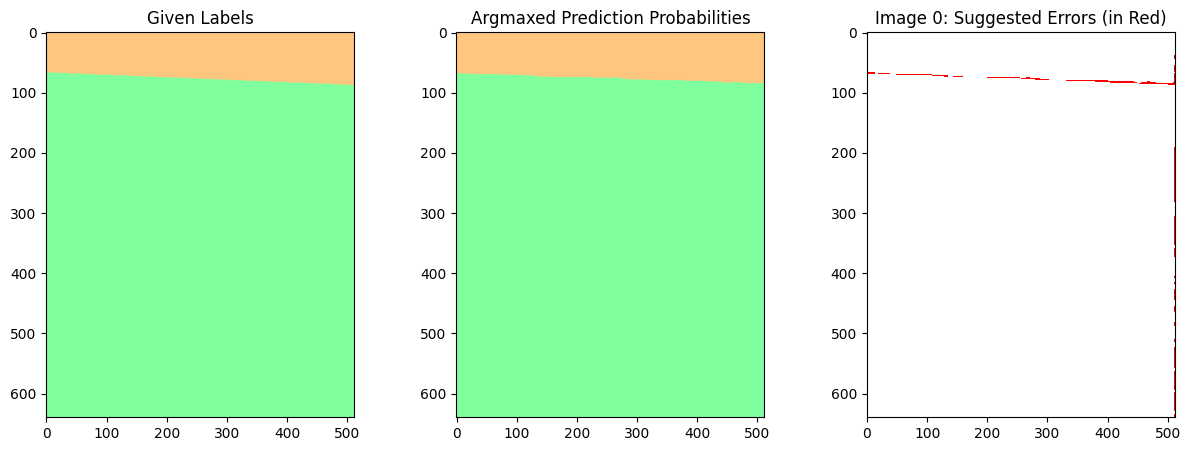

In [91]:
# issues = find_label_issues(ground_truth_labels_all_np, pred_probs_all_np, downsample = 4, n_jobs=None, batch_size=1)
# image_scores, pixel_scores = get_label_quality_scores(labels=ground_truth_labels_all_np, pred_probs=pred_probs_all_np)
# issues_from_score = issues_from_scores(image_scores, pixel_scores, threshold=0.5)

display_issues(issues_from_score, labels=ground_truth_label, pred_probs=pred_probs_np, top=5)

In [90]:
issues = find_label_issues(ground_truth_labels_all_np, pred_probs_all_np, downsample = 4, n_jobs=None, batch_size=8)
image_scores, pixel_scores = get_label_quality_scores(labels=ground_truth_labels_all_np, pred_probs=pred_probs_all_np)

number of examples processed for estimating thresholds:   0%|          | 0/10 [00:00<?, ?it/s]

number of examples processed for checking labels:   0%|          | 0/10 [00:00<?, ?it/s]

Total number of examples whose labels have been evaluated: 204800


images processed using softmin:   0%|          | 0/10 [00:00<?, ?it/s]